Implementing a basic DE solver for the neutrino winds in terms of psi

Runge-Kutta method from Wikipedia:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/25f03454fd25957cc63be11ec534efdce349c52f">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/95bdbb2e3aa83735085c0aadd577162c69e4056a">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/81398071e8f180ac143bfdf4598ff47bf79eb689">
I use $\psi$ in place of t, and {r,v} as y. I calculate separate k values for r and v to get y'={r',v'}

Questions/next steps:

Isentropic wind with ideal gas equation of state<br />
check small v0 - no turnover I can find<br />
check limits of gamma, maybe find v0 as a function of gamma<br />
calculate realistic a value<br />
incorporate general EoS, not just gamma law

v vs r:
T vs r:
T vs v:


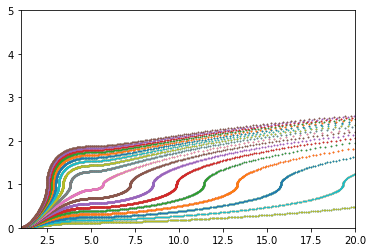

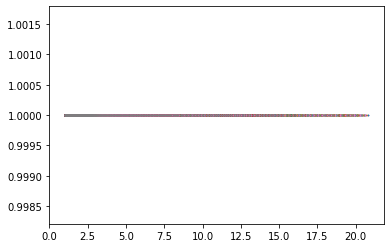

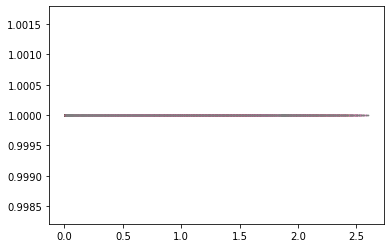

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Adiabatic_wind_solver as aws
s=aws.solver(1,10)
s.makePlots(.001,.01,.0005,True,20,5);

v vs r:
T vs r:
T vs v:


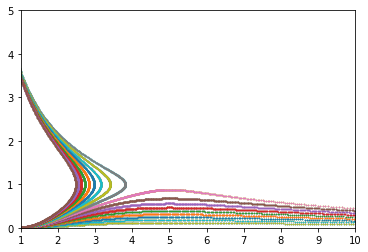

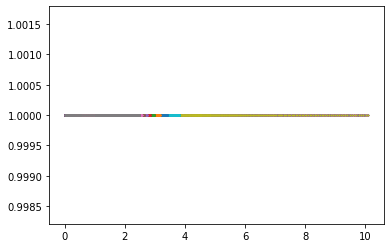

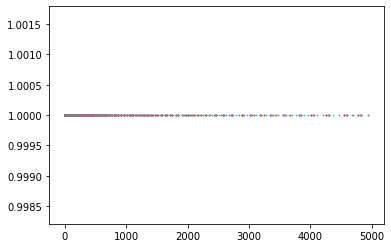

In [6]:
s.makePlots(.001,.01,.0005,False,10,5);

Lower bound on v0:  0.005075313377380374
Upper bound on v0:  0.005075325393676755
Estimated v0:  0.005075319385528564
Estimated error:  6.008148190333323e-09


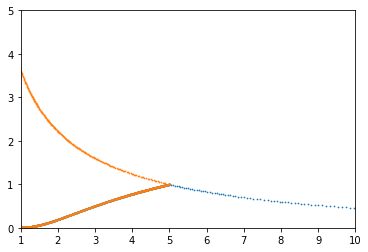

In [7]:
v0avg=s.findV0(.004,.006,.0001)

Max iteration count exceeded in adaptation


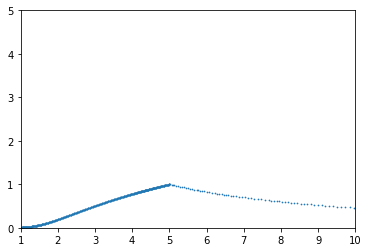

In [11]:
s.makePlot(v0avg,AV=False,xrange=10);

True
True
0.7145761164770619


0

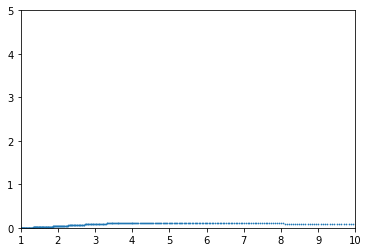

In [18]:
print(type(np.array([s.dx,s.du]))==np.ndarray)
print(np.shape([1,[2,3,4]])==(2,))
gamma=1
print(s.generateFunc(np.array([1,.001,0]))[2][-1])
s.makePlot(.001,AV=False,xrange=10)